In [1]:
%cd "C:/Users/first/Desktop/Machine_Learning1/Final_Project

C:\Users\first\Desktop\Machine_Learning1\Final_Project


In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
import sys
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sn
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
import plotly.express as px
import plotly.graph_objects as go
from dash.dependencies import Input, Output
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Final Project for DTSA-5509
#### Ethan Tucker
#### 4/25/22

## Introduction and Problem Description

Welcome to my final project for DTSA-5509! Before running this notebook, please ensure you have all required dependancies installed in your build. All required packages are listed above. Also if you intend to run this notebook, ensure to place the folder extracted from the data source called "Rice_Images_Dataset" containing the image data into a fresh directory called "data", and set your local directory to contain "data". As a note, the dataset is reasonably large (~1 GB), so download may take a while. Thanks for taking the time to grade my work!

For this project I wanted to gain some experience using computer vision software. For our programming assignments we worked with image data, but we never got to import and clean the data ourselves. I went onto [kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset) and found a reasonably standard image dataset containing 5 files, each directory exclusively containing images of a specific rice grain. The possible grain types were:

1. Arborio, 

2. Basmati,

3. Ipsala,

4. Jasmine,

5. Karacadag.

According to the kaggle listing, the data were collected ostensibly to help in industrial rice seperators. I'm just interested in giving myself an introduction to computer vision! The obvious ML task is to classify rice grain by image. I'll use two different ML models that we learned in this course:

1. A KNN Classifier

2. An AdaBoost Classifier

I will use sklearn.model_selection.GridSearchCV() to tune the hyper-parameters, but I'll also make graphs to show how and why GridSearchCV is making decisions.



## Exploratory Data Analysis

Along with the image data themselves, the authors have created a companion dataset which creates physical metrics for each rice grain. This dataset can be downloaded as "Rice MSC Dataset" from https://www.muratkoklu.com/datasets/. I will perform EDA on this dataset instead of the image dataset because the created metrics are much more human-understandable than individual pixel brightnesses. Please download this data and put it in your "./data" directory before proceeding with EDA. The codebook for each feature can be found in CINAR, I. and KOKLU, M. (2021). We will only be using some of the variables in the dataset for this EDA - they are printed out in the cell after loading in the data. I chose these features because they represent physical characteristics of the grain itself, rather than abstract statistics.

In [3]:
path = "./data/Rice_MSC_Dataset/Rice_MSC_Dataset.xlsx"
sheet_name = "Rice_MSC_Dataset"
EDAdata = pd.read_excel(path, sheet_name = sheet_name, usecols = "A:P, DC")
EDAdata.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,CLASS
0,7805,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985,0.3547,4.3693,0.5114,0.4751,0.0269,0.0062,0.2257,0.9863,Basmati
1,7503,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767,0.6637,1.9807,0.8120,0.7065,0.0184,0.0093,0.4992,0.9888,Arborio
2,5124,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271,0.4760,3.0482,0.6505,0.5689,0.0277,0.0091,0.3236,0.9865,Jasmine
3,7990,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272,0.6274,3.9325,0.5256,0.5007,0.0252,0.0064,0.2507,0.9859,Basmati
4,7433,342.893,140.3350,68.3927,0.8732,97.2830,0.9831,7561,0.6006,2.0519,0.7944,0.6932,0.0189,0.0092,0.4806,0.9860,Arborio


In [4]:
#This cell prints the features we will be using in the EDA. All other features in Rice_MSC_Dataset seem to be statistical calculations, which may not have 
## direct physical meaning (have to do with orientation on image?)

for col in EDAdata.columns:
    print(col)

AREA
PERIMETER
MAJOR_AXIS
MINOR_AXIS
ECCENTRICITY
EQDIASQ
SOLIDITY
CONVEX_AREA
EXTENT
ASPECT_RATIO
ROUNDNESS
COMPACTNESS
SHAPEFACTOR_1
SHAPEFACTOR_2
SHAPEFACTOR_3
SHAPEFACTOR_4
CLASS


### Correlation Matrix

The first thing I'd like to investigate is the correlation between physical parameters across all grains for collinearity purposes, and then investigate the specific variation in physical parameters across the different grains. I'll start with a correlation matrix:

<AxesSubplot:>

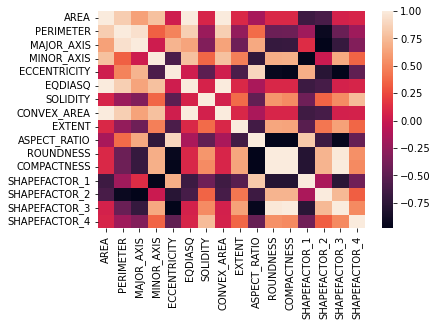

In [5]:
corrMatrix = EDAdata.corr()
sn.heatmap(corrMatrix)

Quick analysis of correlation matrix: there are many highly covariant features. Some seem to be direct functions of others such: as area being calculated from the major and minor axis lengths, eccentricity also being a function of major and minor axis length, etc. The dataset is highly multicollinear. As such when creating a classifier from this data it is important to only choose some features deemed sufficiently independant. 

### Violin Plots

To show the variation in physical paramters between grain types, I'll use violin plots. To prevent clutter by plotting 16 different violin plots (that's 80 total violins!), I'll use a barebones dash app to allow the user to select which feature they'd like to investigate. To launch the app, just run the below chunks (you may need to run them twice in case an error occurs), and then click on the webpage that app.run_server() generates. Plotly uses all the data available to it, so it may take a few seconds to generate violin plots. Enjoy!



In [6]:
app = JupyterDash(__name__)

colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
    
    dcc.Tabs([
        
        dcc.Tab(label='', children=[
            
            html.H1(
                children='Violin Plots of Feature Distributions',
                style={'textAlign': 'center','color': colors['text']}),
            
            html.Div(
                children='Please select a feature you would like to know the distribution of below. Interaction options are in the upper right of the plot.', 
                style={'textAlign': 'center','color': colors['text']}),

            dcc.Graph(id='Violin_Plot'),
            
            dcc.Dropdown(
                id='Violin_Dropdown',
                options=[
                    {'label': 'AREA', 'value': 'AREA'},
                    {'label': 'PERIMETER', 'value': 'PERIMETER'},
                    {'label': 'MAJOR_AXIS', 'value': 'MAJOR_AXIS'},
                    {'label': 'MINOR_AXIS', 'value': 'MINOR_AXIS'},
                    {'label': 'ECCENTRICITY', 'value': 'ECCENTRICITY'},
                    {'label': 'EQDIASQ', 'value': 'EQDIASQ'},
                    {'label': 'SOLIDITY', 'value': 'SOLIDITY'},
                    {'label': 'CONVEX_AREA', 'value': 'CONVEX_AREA'},
                    {'label': 'EXTENT', 'value': 'EXTENT'},
                    {'label': 'ASPECT_RATIO', 'value': 'ASPECT_RATIO'},
                    {'label': 'ROUNDNESS', 'value': 'ROUNDNESS'},
                    {'label': 'COMPACTNESS', 'value': 'COMPACTNESS'},
                    {'label': 'SHAPEFACTOR_1', 'value': 'SHAPEFACTOR_1'},
                    {'label': 'SHAPEFACTOR_2', 'value': 'SHAPEFACTOR_2'},
                    {'label': 'SHAPEFACTOR_3', 'value': 'SHAPEFACTOR_3'},
                    {'label': 'SHAPEFACTOR_4', 'value': 'SHAPEFACTOR_4'}
                ],
                value = "AREA",
                placeholder = "Select a variable for the x - axis"),
            
            html.Br()
        
        ]),
    ])
    ])


@app.callback(
    Output('Violin_Plot', 'figure'),
    Input('Violin_Dropdown', 'value')

)
def changeViolinAxis(value):
    """
        This callback generates a new violin plot for the x-axis upon user selection
        Input: string value, which is a feature name to be plotted
        Output: plotly.express.violin figure
    """
    fig = px.violin(EDAdata, x = value, color="CLASS",  
                    color_discrete_sequence=["white", "#d62728"],
                    box=True, hover_data=EDAdata.columns,
                    title="Probability Density")

    fig.update_layout(
        plot_bgcolor=colors['background'],
        paper_bgcolor=colors['background'],
        font_color=colors['text'],
        height = 750
    )

    fig.update_xaxes(rangemode="tozero")
    fig.update_yaxes(rangemode="tozero")
            
    
    return(fig)

In [7]:
app.run_server()

Dash app running on http://127.0.0.1:8050/


## Data Pre-Processing and Importation

The data importation went reasonably smoothly primarily because all the rice types were only in one file, making the generation of a label vector trivial. The entire dataset was a bit over a gigabyte - there were $15000$ images of each type of rice and they were all $(256, 256)$ jpg's. That's clearly too much to train multiple models on in any given reasonable timescale, especially if I want to tune the hyperparameters. My solution was to rescale the images down to a pre-specified size. I chose $(30, 30)$, which results in $30^2 = 900$ features. For reference, the handwriting programming assignment only used $(28, 28)$ image data, so $(30, 30)$ seems reasonable for images approximately of the same complexity. We need more data than features or else the design matrix becomes singular, so at a minimum we would require 900 datapoints per rice category to estimate all the parameters. I chose $n_{\text{each}} = 3000$ to allow for good estimates of standard error thus improving model performances.

For conversion from image to numerical data I used cv2.imread(filepath, 0) which reads in the image in grayscale. This works very well because rice is white! The backgrounds were black to begin with which likely assists in model accuracy.

In [8]:
def readRiceType(current_data, current_labels, n_each, pix, path):
    """
        Appends image data to current_data, and labels to current_labels
        Input:  list current_data, 
                list current_labels,
                int n_each, 
                int pix, 
                string path. path should be of the form ./data/Rice_Image_Dataset/RiceType/
        Output: double (current_data, current_labels)
    """
    # Don't need to loop over label generation because all rice are same type
    this_label = path[26:-1]

    for img in os.listdir(path)[:n_each]:
        filepath = path + img
        pic = cv.imread(filepath, 0)
        pic = cv.resize(pic, (pix, pix)) # If performance allows, increase resize!
        # An interesting project would be for an (n, n) image, model performance vs n.
        current_data.append([pic])
        current_labels.append(this_label)
        
    return (current_data, current_labels)

#Load in 3000 rice of each type w/ chosen hyperparams
types_of_rice = os.listdir("./data/Rice_Image_Dataset/")[:-1]
data = []
labels = []
n_each = 3000 # Could increase if performance allows!
pix = 30

for rice_type in types_of_rice:
    path = "./data/Rice_Image_Dataset/" + rice_type + "/"
    (data, labels) = readRiceType(data, labels, n_each, pix, path)
    


savePath = "./data"
np.save(os.path.join(savePath,'features'),np.array(data))
features = np.load(os.path.join(savePath,'features.npy'))[:, 0, :, :]
total_rice = n_each * 5 # There are five grain types

assert total_rice == len(features)

features = features.reshape(total_rice, pix**2)
labels = np.asarray(labels)
np.save(os.path.join(savePath, "labels"), labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.20, random_state = 0)


# Analysis and Results

## KNN Classifier

I will use sklearn for models in this project. The KNN classifier I use is sklearn.neighbors.KNeighbors(). My computer has 16 processors in CPU0, so I pass n_jobs = -1 to expedite model creation - remove this argument if you want to retain CPU functionality while models are being constructed. This may additionally cause an error if you don't have at least 14 processors in CPU0. 

In [13]:
KNN = KNeighborsClassifier()
param_to_try = {"n_neighbors" : [i for i in range(1, 11)]}
grid = GridSearchCV(estimator = KNN, param_grid = param_to_try, n_jobs = -1)

grid.fit(X_train, y_train)

print(grid.best_params_ , grid.best_score_)

{'n_neighbors': 4} 0.9661666666666667


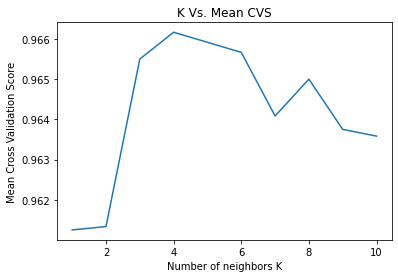

In [15]:
KNN_results_dic = grid.cv_results_
KNN_results = pd.DataFrame(KNN_results_dic)
n_neighbors = list(KNN_results["param_n_neighbors"])
mean_score = list(KNN_results["mean_test_score"])

# This plots n_neighbors vs mean test score

plt.plot(n_neighbors, mean_score)
plt.xlabel("Number of neighbors K")
plt.ylabel("Mean Cross Validation Score")
plt.title("K Vs. Mean CVS")
plt.show()

In [16]:
bestKNN = grid.best_estimator_
yhat = bestKNN.predict(X_test)
model_accuracy = accuracy_score(y_true = y_test, y_pred = yhat)

print(model_accuracy)

0.9723333333333334


### KNN Classifier Analysis:

In general, KNN classifiers run into issues when the user picks too high a value for K. High dimensional data can be quite sparse, and so allowing K to range too high amounts to the introduction of noise into the model. I ran a GridSearchCV on the data using 5-fold cross validation to optimize accuracy over a range of possible K values. The results are plotted above. K = 4 was the optimal choice as measured by mean CVS. The corresponding mean CVS was 0.966. The K = 4 model returned a test accuracy of 0.972, which is quite good for a 5 category classifier.

## AdaBoost Classifier

The base tree I will use is a sklearn DecisionTreeClassifier (obviously, we're doing classification). This chunk will take a while to run, because AdaBoost classifiers cannot be parallelized! 

In [26]:
classifier = DecisionTreeClassifier(max_depth = 3)
n_trees = 50
AdaBoost = AdaBoostClassifier(base_estimator = classifier, n_estimators = n_trees, random_state = 0)

AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   random_state=0)

In [27]:
yhat = AdaBoost.predict(X_test)
model_accuracy = accuracy_score(y_true = y_test, y_pred = yhat)

print(model_accuracy)

0.78


## AdaBoost Classifier Analysis

AdaBoost classifiers strictly get better as a function of the number of trees. As such we can skip a costly call to GridSearchCV and just specify the number of trees we are willing to pay for. That said, as is clear from this example adaBoost classifiers converge quite slowly. This is a reason why Random Forests are a popular ensemble where computation time is a concern. The model accuracy was not even close to being as accurate as the KNN classifier, and it took much longer to train. For a sufficiently high number of trees or a sufficiently long train time, it is likely that the accuracy of the adaBoost classifier can be made to exceed that of the KNN classifier, but not at any reasonable level of expense. 

# Discussion / Conclusion

For this project I wanted experience handling image data and using computer vision libraries. I gained experience with the cv2 library, and learned how to efficiently convert images from .jpg's to MAT format. According to the documentation, cv2.imread() works not only for .jpgs but many different image filetypes, which makes it a very useful tool! In the future I want to try using the edge analysis methods included in the software to expedite model construction.

The EDA performed shows that the different rice grains have vastly differnent distributions of their physical characteristics. As such it becomes meaningful to create classification models using their physical appearance. This data was quite clean from the get go - next time I'd like to use some messier data to get practice cleaning image data. That said, libraries such as pandas, cv2, and pillow are so extensive that I can't image any cleaning would be that difficult. 

In terms of the models constructed, the KNN classifier vastly outperformed the adaBoost classifier both in computation time and more importantly accuracy. The accuracy of the best KNN model was $97.2 \%$ on the test data! The adaBoost only yielded $78\%$ for the specified tree count. As previously stated, we could wait until the end of time for an adaBoost with thousands of trees to train, but I'd rather use my life for something better. In retrospect, a random forest classifier would have executed faster because I could parallelize the training using an n_jobs argument. Lesson learned.

Thank you for taking the time to grade my work, and I look forward to seeing yours!

-Ethan Tucker

# Bibliography:

[Kaggle Listing](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)

Data can be downloaded at https://www.muratkoklu.com/datasets/ under "Rice Image Dataset" as of 4/25/22. As follows are the requested citations:

1: KOKLU, M., CINAR, I. and TASPINAR, Y. S. (2021). Classification of rice varieties with deep learning methods. Computers and Electronics in Agriculture, 187, 106285.

DOI: https://doi.org/10.1016/j.compag.2021.106285

2: CINAR, I. and KOKLU, M. (2021). Determination of Effective and Specific Physical Features of Rice Varieties by Computer Vision In Exterior Quality Inspection. Selcuk Journal of Agriculture and Food Sciences, 35(3), 229-243.

DOI: https://doi.org/10.15316/SJAFS.2021.252

3: CINAR, I. and KOKLU, M. (2022). Identification of Rice Varieties Using Machine Learning Algorithms. Journal of Agricultural Sciences, 28 (2), 307-325.

DOI: https://doi.org/10.15832/ankutbd.862482

4: CINAR, I. and KOKLU, M. (2019). Classification of Rice Varieties Using Artificial Intelligence Methods. International Journal of Intelligent Systems and Applications in Engineering, 7(3), 188-194.

DOI: https://doi.org/10.18201/ijisae.2019355381



Great documentation sources I used:

1. https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html

2. https://pythonprogramming.altervista.org/pixelize-an-image-with-pil-and-python/?doing_wp_cron=1650869345.1507990360260009765625

3. https://medium.com/analytics-vidhya/create-your-own-real-image-dataset-with-python-deep-learning-b2576b63da1e

# System Information

In [260]:
import platform
print(platform.platform())
print(platform.processor())
print(platform.python_version())

Windows-10-10.0.19044-SP0
Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
3.9.7
